# Predicting the price of Heating Oil using PyCaret
In this notebook, we'll go over how to perform a time series forecasting on the price of heating oil.

## Background
In update New York, we are unable to get natural gas to service our home for heating. This is because the rock is mostly made of shale, which makes it tough to get pull natural gas. So we have to rely on oil for heat.

As the price of gas goes up and down, the price of heating oil is the same. There are many companies that distribute oil and all of them have different prices. Also, these prices change between seasons. So, I wanted to build an application that predicts the price of oil, so that I know when is the best time to buy.

## Data
Before building the models, i needed to get data. I have been unable to find a dataset with the current price of oil, therefore I had to build my own. The website cheapestoil.com shows the price of oil for many companies in the northeast United States. The site shows the latest prices for these companies, but they do not show the previous prices. 

So in order to get the prices, I build a AWS lambda function that scrapes the price of oil daily. I used AWS CloudWatch events to run a lambda function every 12 hours, in order to fetch the prices for that time. This lambda extracted the last updated date, price and supplier, and save these results as JSON and save  to an S3 bucket. After the json data is saved, I have another lambda function, attached as a trigger, to read each json file, and save into DynamoDB.  Please see the GitHub repo on more detail on how I build these lambda functions. 

I started this project back in Dec 2020 in order to build up my dataset. The lambda function has been running for about 6 months, and I have a decent amount of data to work with. In order to expand my dataset, I was able to pull more data using The Wayback Machine on web.archive.org. The Wayback Machine stores a snapshot of many pages on the internet. It doesn't have every site, but it did have some snapshots from cheaptestoil.com. To get that data, I used https://github.com/hartator/wayback-machine-downloader to download the archive data. The archive only had 7 snapshots, between the dates of Aug 2020 and Oct 2021. 

In all, I have about 5k records of all the oil prices from the website

## Fetching Saved Data
I used DynamoDB to store the oil price data, and used Boto3 to fetch the data, which I then save to a CSV.


In [326]:
import boto3
from boto3.dynamodb.conditions import Key
import pandas as pd
dynamodb = boto3.resource('dynamodb')

table = dynamodb.Table('heating_oil_prices')
response = table.scan()
df = pd.DataFrame(response["Items"])
df.to_csv("data.csv")

In [327]:
def get_data():
    df = pd.read_csv("data.csv", usecols=["last_updated", "price150","price500", "price300", "supplier", "state"])
    df["last_updated"] = pd.to_datetime(df["last_updated"])
    df = df.set_index("last_updated")
    df["state"] = df["state"].apply(lambda x: "NewYork" if str(x) == "nan" else x)
    df = df.sort_index()
    return df
df = get_data()

On Cheapestoil.com, the have the price of oil in gallons, but the price is slightly different for how many gallons you buy. If we get suppliers in the state of New York, we'll see the following

In [328]:
    state = "NewYork"
    suppliers_by_state = df[ (df["state"] == state)].dropna()
    suppliers_by_state.iloc[1]


price500          1.449
price300          1.469
price150          1.549
supplier    Suffolk Oil
state           NewYork
Name: 2020-08-03 15:11:16, dtype: object

The row above shows that the price for 500 gallons(`price500`) is $1.449 per gallon, 300 gallons(`price300`) is $1.69 and 150 gallons(`price150`) is $1.549

Lets see how many suppliers we have for New York

In [329]:
suppliers_by_state["supplier"].value_counts().sum()

2708

Since we have so many suppliers, a forecasr for the average price of oil for all the suppliers might be a better way to go, since the prices are simlar between every company

In [330]:
df = df.reset_index()
data = df[ df["state"] == state].resample('d', on='last_updated').mean().dropna()
data = data.reset_index()

Here is the mean price of oil over all the suppliers in New York.

In [331]:
data.head()

,last_updated,price500,price300,price150
0,2020-08-03,1.672000,1.719400,1.76140
1,2020-08-04,1.632429,1.625750,1.68075
2,2020-10-29,1.852500,1.819455,1.85300
3,2020-11-11,1.786250,1.759000,1.76900
4,2020-11-12,1.420000,1.460000,1.54000


For a quick check on our data, let's plot the price for 500 gallons

<AxesSubplot:>

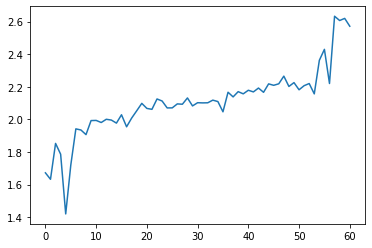

In [332]:
data["price500"].plot()


# Model

Now, we can start building our model. We'll be using PyCaret to build our time series forecast. 
Before modeling, we need to update the dataset to remove the date and replace with numeric values. To do this, I've included fastai's `add_datepart` function to convert the data is series of features, split by year, month, day, day of week, and much more

In [333]:
from fastai.tabular.all import *
add_datepart(data, field_name="last_updated")

,price500,price300,price150,last_updatedYear,last_updatedMonth,last_updatedWeek,last_updatedDay,last_updatedDayofweek,last_updatedDayofyear,last_updatedIs_month_end,last_updatedIs_month_start,last_updatedIs_quarter_end,last_updatedIs_quarter_start,last_updatedIs_year_end,last_updatedIs_year_start,last_updatedElapsed
0,1.672000,1.719400,1.761400,2020,8,32,3,0,216,False,False,False,False,False,False,1.596413e+09
1,1.632429,1.625750,1.680750,2020,8,32,4,1,217,False,False,False,False,False,False,1.596499e+09
2,1.852500,1.819455,1.853000,2020,10,44,29,3,303,False,False,False,False,False,False,1.603930e+09
3,1.786250,1.759000,1.769000,2020,11,46,11,2,316,False,False,False,False,False,False,1.605053e+09
4,1.420000,1.460000,1.540000,2020,11,46,12,3,317,False,False,False,False,False,False,1.605139e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2.220000,2.260000,2.340000,2021,6,26,28,0,179,False,False,False,False,False,False,1.624838e+09
57,2.632621,2.626935,2.646290,2021,7,26,2,4,183,False,False,False,False,False,False,1.625184e+09
58,2.606429,2.582633,2.611437,2021,7,27,5,0,186,False,False,False,False,False,False,1.625443e+09
59,2.619422,2.609042,2.632478,2021,7,27,6,1,187,False,False,False,False,False,False,1.625530e+09


The `add_datepart` function generates lots of feature for the date, but we don't need to use all of them. For this model, we'll use `last_updatedYear`,  `last_updatedMonth` and `last_updatedDay`. In future models, we can try to use other features.

In [334]:
data = data[['price500', 'last_updatedYear', 'last_updatedMonth', 'last_updatedDay']]

In [335]:
mask = round(len(data) * 0.7)
train = data[:mask]
test = data[mask:]
train.shape, test.shape

((43, 4), (18, 4))

After we split the data into a train, test set, we then must initalize the regression setup in PyCaret. This includes suppling the dataset, the feature we are predicting on (`price500`) and the other features to use(`last_updatedYear`,`last_updatedMonth` and `last_updatedDay`)

In [336]:
from pycaret.regression import *
s = setup(data = train, test_data = test, target = 'price500', fold_strategy = 'timeseries', numeric_features = ['last_updatedYear','last_updatedMonth', 'last_updatedDay'], fold = 3, transform_target = True, session_id = 42)

,Description,Value
0,session_id,42
1,Target,price500
2,Original Data,"(43, 4)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(43, 3)"


Next we call the `compare_models` function to find the best model using the Mean Absolute Error(MAE), which is the mean of the absolute difference between the  models prediction and expected values.   

In [338]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,0.0605,0.0056,0.0678,-2.2270,0.0221,0.0288,1.4700
ada,AdaBoost Regressor,0.0796,0.0175,0.1127,-47.4081,0.0379,0.0378,1.0000
dt,Decision Tree Regressor,0.0857,0.0213,0.1198,-60.1246,0.0406,0.0407,1.0700
xgboost,Extreme Gradient Boosting,0.0865,0.0214,0.1209,-60.2439,0.0410,0.0411,1.1267
et,Extra Trees Regressor,0.0877,0.0217,0.1234,-60.1248,0.0418,0.0417,0.2433
gbr,Gradient Boosting Regressor,0.0886,0.0222,0.1259,-61.1376,0.0426,0.0420,0.9667
rf,Random Forest Regressor,0.0933,0.0218,0.1306,-56.2358,0.0440,0.0442,1.3233
catboost,CatBoost Regressor,0.0958,0.0238,0.1333,-63.3711,0.0451,0.0454,0.1933
en,Elastic Net,0.1083,0.0192,0.1341,-36.1485,0.0448,0.0516,1.4000
knn,K Neighbors Regressor,0.1240,0.0223,0.1485,-33.7511,0.0493,0.0587,1.5300


From the results above, it looks like the 	Passive Aggressive Regressor has the lowest MAE error(0.0605), so we'll use that model on the test set

In [ ]:
preds = predict_model(best)

Next, we'll use this model and generate a forecast for the next 7 days worth of prices 


In [ ]:
forecast_df = pd.DataFrame()
forecast_df["last_updated"] = pd.date_range(start='2021-07-08', periods=8)
add_datepart(forecast_df, 'last_updated')
forecast_df = forecast_df[['last_updatedYear', 'last_updatedMonth', 'last_updatedDay']]
forecast_df

In [ ]:
predictions = predict_model(best, data=forecast_df)
predictions

Once we make our predictions, we'll then merge the predictions to the orginal data and plot the last 15 days in the dataframe

In [ ]:
def pad_value(day):
    value = str(int(day))
    print()
    if len(value) ==1:
        return f'0{value}'
    return value

results_df = pd.concat([data,predictions], axis=0)
dates = []
for idx, x in results_df.iterrows():
    date_str =  f'{pad_value(x["last_updatedYear"])}-{pad_value(x["last_updatedMonth"])}-{pad_value(x["last_updatedDay"])}'
    dates.append(pd.to_datetime(date_str, format='%Y-%m-%d'))
results_df["date"] = dates

results_df.drop(["last_updatedYear", "last_updatedMonth", "last_updatedDay"], axis=1,inplace=True)
results_df = results_df.set_index('date')


In [ ]:
results_df[-15:].plot()

The blue line above shows the actual prices and the orange are the predicitons, which do not look the best. If we zoom in to the predictions. we'll see a increasing in price per day

In [ ]:
results_df[-8:].plot()

# Saving The Model

After we trained our model, we can now save and use for forecasting on other data

In [341]:
save_model(best, "model")

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['last_updatedYear',
                                                           'last_updatedMonth',
                                                           'last_updatedDay'],
                                       target='price500', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_ca...
                                                  regressor=PassiveAggressiveRegressor(C=1.0,
                                                                                       average=False,
                                                                 

# Training Model for all Prices

After we have a intial model, we can now train 3 seperate models for each price(`price150`, `price300` and `price500`)
We'll refactor the model training code into a function that trains each price, gets the model with the best score, and saves the model to a seperate file

In [344]:
def train(data, price, state="NewYork"):
    data = data.reset_index()
    data = data[ data["state"] == state].resample('d', on='last_updated').mean().dropna()
    data = data.reset_index()
   
    add_datepart(data, field_name="last_updated")
    data = data[[price, 'last_updatedYear', 'last_updatedMonth', 'last_updatedDay']]   
    mask = round(len(data) * 0.7)
    train = data[:mask]
    test = data[mask:]
    print("train",train.shape)
    print("test",test.shape)

    s = setup(data = train, test_data = test, target = price, fold_strategy = 'timeseries', numeric_features = ['last_updatedYear','last_updatedMonth', 'last_updatedDay'], fold=2, transform_target = True, session_id = 42)
    best = compare_models(sort = 'MAE')
    save_model(best, f'{price}_model')

In [346]:
for feature in ["price150", "price300", "price500"]:
    df = get_data()
    train(df, feature)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,0.1527,0.0256,0.1589,-12.2045,0.0525,0.0725,2.8800
lightgbm,Light Gradient Boosting Machine,0.1527,0.0256,0.1589,-12.2045,0.0525,0.0725,1.4350
en,Elastic Net,0.1897,0.0445,0.1985,-24.4001,0.0663,0.0897,2.3550
lasso,Lasso Regression,0.1909,0.0426,0.1988,-22.9305,0.0663,0.0903,2.2350
omp,Orthogonal Matching Pursuit,0.2048,0.0525,0.2156,-28.9051,0.0723,0.0968,1.4600
knn,K Neighbors Regressor,0.2072,0.0600,0.2195,-33.8002,0.0737,0.0975,2.5650
par,Passive Aggressive Regressor,0.2270,0.0752,0.2331,-34.7248,0.0797,0.1088,2.8350
ada,AdaBoost Regressor,0.2467,0.1032,0.2674,-59.6300,0.0924,0.1157,1.4250
rf,Random Forest Regressor,0.2528,0.0963,0.2642,-55.4536,0.0901,0.1189,1.7600
catboost,CatBoost Regressor,0.2567,0.0993,0.2686,-57.1565,0.0918,0.1208,0.2600


Transformation Pipeline and Model Succesfully Saved


# Conclusion and What's Next

In this post, we've seen how to build a time series model for forecasting the price of heating oil. In the next post, we'll go over how to deploy these models into a StreamLit application.
We'll also go over how the process on how the data was collected.